In [1]:
import os

os.chdir("../../../..")

os.getcwd()

'c:\\Users\\mquick\\Documents\\zeitgeist blog\\projects\\geopolitical_proximity'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from utils.types.variables import pct_world_exports, pct_world_gdp, pct_rd_spending
from utils.tools.world_bank import WBDataHandler
from utils.tools.impute import Imputer

### % world GDP

* [Source](https://tradingeconomics.com/north-korea/gdp) for PRK GDP estimates
* RoW from World Bank

In [27]:
gdp_code = "NY.GDP.MKTP.CD" # has Venezuela data, whereas NY.GDP.MKTP.CD has none

In [28]:
gdp_handler = WBDataHandler(variable=pct_world_gdp)

In [29]:
gdp_df = gdp_handler.get_data(indicator_code=gdp_code, from_year=1960, to_year=2023)

In [30]:
wld_gdp_df = gdp_df.loc[gdp_df["countryiso3code"]=="WLD", ["date", "value"]].rename(columns={"value":"sum"})
gdp_df = gdp_df.merge(wld_gdp_df, on="date", how="inner")

In [31]:
nodes_gdp_df = gdp_handler.keep_nodes_only(raw_indicator_df=gdp_df)

In [32]:
nodes_gdp_df.head(3)

,date,value,is_imputed,sum,node_id,iso3
0,1960,NaN,NaN,1.364504e+12,1,AFG
1,1961,NaN,NaN,1.439319e+12,1,AFG
2,1962,NaN,NaN,1.542845e+12,1,AFG


In [33]:
nodes_gdp_df["value_pct"] = (nodes_gdp_df["value"] / nodes_gdp_df["sum"]) * 100

In [34]:
imputer = Imputer(group_by_col="iso3")

In [35]:
gdp_missing = imputer.pct_completeness_by_group(dataframe=nodes_gdp_df, value_col="value_pct")

In [43]:
gdp_missing[gdp_missing["complete_pct"]<1]

,iso3,complete_pct
0,AFG,0.36
1,AGO,0.48
2,ALB,0.62
3,AND,0.84
4,ARE,0.84
...,...,...
185,VEN,0.86
186,VNM,0.61
187,VUT,0.70
188,WSM,0.84


In [36]:
interpolated_gdp_df = imputer.interpolate_values(dataframe=nodes_gdp_df)

In [37]:
gdp_carried_values = imputer.carry_values(dataframe=interpolated_gdp_df, value_col="value_pct", max_consec=5)

In [38]:
interpolated_gdp_df["value_pct_carried"] = gdp_carried_values

In [39]:
interpolated_gdp_df["value_pct_extrapol"] = imputer.extrapolate_values(dataframe=interpolated_gdp_df, 
                                                                       x_col="date", 
                                                                       y_col="value_pct_carried", 
                                                                       floor=0,
                                                                       ceiling=100
                                                                       )

In [55]:
gdp_missing = imputer.pct_completeness_by_group(dataframe=interpolated_gdp_df, value_col="value_pct_extrapol")

In [56]:
gdp_missing[gdp_missing["complete_pct"]<1]

,iso3,complete_pct
141,PRK,0.0


In [40]:
prk_gdp = pd.read_csv("./notebooks/nodes/data/PRK_GDP_estimates.csv")

In [41]:
prk_gdp["GDP"] = prk_gdp["GDP"] * 1e9

In [42]:
interpolated_gdp_df = interpolated_gdp_df.loc[interpolated_gdp_df["iso3"]!="PRK"]

In [43]:
prk_multiindex = pd.MultiIndex.from_product(iterables=[[year for year in range(1960, 2024)], ["PRK" ]], names=["date", "iso3"])

In [44]:
prk_gdp = prk_gdp\
    .assign(iso3 = "PRK")\
    .set_index(["date", "iso3"])\
    .reindex(prk_multiindex)\
    .reset_index()\
    .assign(node_id = 90)\
    .merge(interpolated_gdp_df[["date", "sum"]].drop_duplicates(), on="date", how="left")
    
prk_gdp.loc[prk_gdp["GDP"].notna(), "is_imputed"] = False

In [45]:
prk_gdp["value_pct_extrapol"] = (prk_gdp["GDP"] / prk_gdp["sum"]) * 100

In [46]:
all_nodes_gdp_df = pd.concat([interpolated_gdp_df, prk_gdp.drop("GDP", axis=1)])

In [47]:
prk_vals = all_nodes_gdp_df.loc[all_nodes_gdp_df["iso3"]=="PRK"]

In [48]:
all_nodes_gdp_df.loc[all_nodes_gdp_df["iso3"]=="PRK", "value_pct_extrapol"] = imputer.carry_values(prk_vals, "value_pct_extrapol", max_consec=5)

In [49]:
all_nodes_gdp_df.loc[all_nodes_gdp_df["iso3"]=="PRK", "value_pct_extrapol"] = imputer.extrapolate_values(dataframe=all_nodes_gdp_df.loc[all_nodes_gdp_df["iso3"]=="PRK"],
                           x_col="date",
                           y_col="value_pct_extrapol",
                           floor=0
                           )

In [91]:
gdp_missing = imputer.pct_completeness_by_group(dataframe=all_nodes_gdp_df, value_col="value_pct_extrapol")

In [92]:
gdp_missing["complete_pct"].min()

np.float64(1.0)

In [93]:
all_nodes_gdp_df["value_norm"] = gdp_handler.normalise_values(dataframe=all_nodes_gdp_df, 
                                                              group_by_col="date",
                                                              raw_values_col="value_pct_extrapol", 
                                                              apply_log=True)

<Axes: xlabel='date', ylabel='value_norm'>

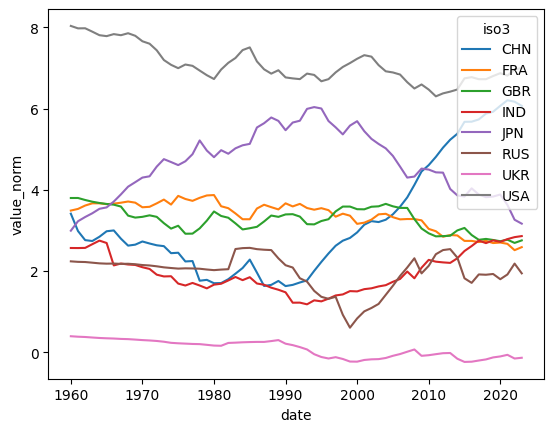

In [95]:
sns.lineplot(data=all_nodes_gdp_df[all_nodes_gdp_df["iso3"].isin(["CHN", "USA", "GBR", "FRA", "IND", "JPN", "RUS", "UKR"])],
             x="date", y="value_norm", hue="iso3"
             )

In [98]:
all_nodes_gdp_df = all_nodes_gdp_df.drop("value", axis=1).rename(columns={"value_pct_extrapol":"value"})

In [99]:
upload_gdp_df = gdp_handler.format_df_for_upload(dataframe=all_nodes_gdp_df)

In [105]:
# gdp_handler.upload_to_bq(dataframe=upload_gdp_df)

### % of world exports

In [106]:
exports_code = "NE.EXP.GNFS.CD"

In [142]:
exports_handler = WBDataHandler(pct_world_exports)

In [143]:
exports_df = exports_handler.get_data(indicator_code=exports_code, from_year=1970, to_year=2023)

In [144]:
wld_gdp_df = exports_df.loc[exports_df["countryiso3code"]=="WLD", ["date", "value"]].rename(columns={"value":"sum"})
exports_df = exports_df.merge(wld_gdp_df, on="date", how="inner")

In [145]:
nodes_exports_df = exports_handler.keep_nodes_only(raw_indicator_df=exports_df)

In [146]:
nodes_exports_df["value_pct"] = (nodes_exports_df["value"] / nodes_exports_df["sum"]) * 100

In [147]:
imputer = Imputer(group_by_col="iso3")

In [148]:
exports_missing = imputer.pct_completeness_by_group(dataframe=nodes_exports_df, value_col="value_pct")

In [149]:
exports_missing[exports_missing["complete_pct"]==0]

,iso3,complete_pct
3,AND,0.0
69,GRD,0.0
92,KNA,0.0
97,LBR,0.0
99,LCA,0.0
100,LIE,0.0
107,MCO,0.0
110,MDV,0.0
116,MMR,0.0
122,MWI,0.0


In [150]:
interpolated_exp_df = imputer.interpolate_values(dataframe=nodes_exports_df)

In [151]:
exports_carried = imputer.carry_values(dataframe=interpolated_exp_df, value_col="value_pct", max_consec=5)
interpolated_exp_df["value_pct_carried"] = exports_carried

In [152]:
interpolated_exp_df["value_pct_extrapol"] = imputer.extrapolate_values(dataframe=interpolated_exp_df, 
                                                                       x_col="date", 
                                                                       y_col="value_pct_carried", 
                                                                       floor=0, 
                                                                       ceiling=100)

In [160]:
exports_missing = imputer.pct_completeness_by_group(dataframe=interpolated_exp_df, value_col="value_pct_extrapol")

In [162]:
exports_missing[exports_missing["complete_pct"]==0]

,iso3,complete_pct
3,AND,0.0
69,GRD,0.0
92,KNA,0.0
97,LBR,0.0
99,LCA,0.0
100,LIE,0.0
107,MCO,0.0
110,MDV,0.0
116,MMR,0.0
122,MWI,0.0


In [163]:
knn_exp_df = interpolated_exp_df.merge(upload_gdp_df[["node_id", "year", "value"]].rename(columns={"value":"pct_world_gdp"}),
                          left_on=["node_id", "date"],
                          right_on=["node_id", "year"],
                          how="left")

In [167]:
knn_exp_df["value_pct_knn"] = imputer.impute_with_knn(dataframe=knn_exp_df, value_col="value_pct_extrapol", cols_for_imputation=["pct_world_gdp"])

In [173]:
exports_missing = imputer.pct_completeness_by_group(dataframe=knn_exp_df, value_col="value_pct_knn")

In [174]:
exports_missing["complete_pct"].min()

np.float64(1.0)

In [175]:
knn_exp_df["value_norm"] = exports_handler.normalise_values(dataframe=knn_exp_df,
                                                            group_by_col="date",
                                                            raw_values_col="value_pct_knn",
                                                            apply_log=True
                                                            )

<Axes: xlabel='date', ylabel='value_norm'>

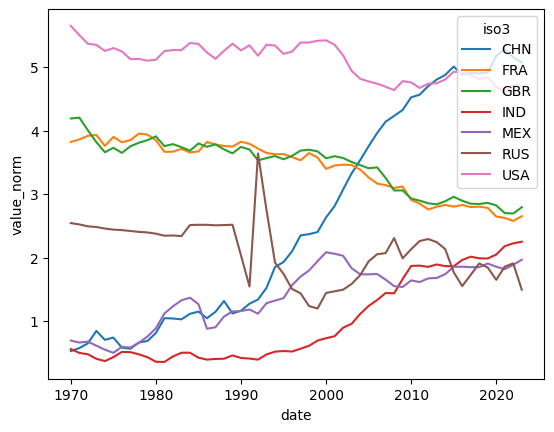

In [177]:
sns.lineplot(data=knn_exp_df[knn_exp_df["iso3"].isin(["USA", "CHN", "MEX", "GBR", "FRA", "IND", "RUS"])],
             x="date", y="value_norm", hue="iso3"
             )

In [178]:
knn_exp_df = knn_exp_df.drop(["value", "year"], axis=1).rename(columns={"value_pct_knn":"value"})

In [180]:
upload_exp_df = exports_handler.format_df_for_upload(dataframe=knn_exp_df)

In [182]:
# exports_handler.upload_to_bq(dataframe=upload_exp_df)

### % of global R&D spending

In [3]:
rd_code = "GB.XPD.RSDV.GD.ZS"

In [4]:
rd_handler = WBDataHandler(variable=pct_rd_spending)

In [5]:
rd_df = rd_handler.get_data(rd_code, from_year=1996, to_year=2023)

In [7]:
nodes_rd_df = rd_handler.keep_nodes_only(raw_indicator_df=rd_df)

In [12]:
imputer = Imputer(group_by_col="iso3")

In [13]:
rd_missing = imputer.pct_completeness_by_group(dataframe=nodes_rd_df, value_col="value")

In [15]:
len(rd_missing[rd_missing["complete_pct"]<1])

193

In [16]:
interpolated_rd_df = imputer.interpolate_values(dataframe=nodes_rd_df)

In [17]:
interpolated_rd_df["value_carried"] = imputer.carry_values(dataframe=interpolated_rd_df,
                                                           value_col="value",
                                                           max_consec=5,
                                                           forwards=True,
                                                           backwards=True
                                                           )

In [19]:
interpolated_rd_df["value_extrapol"] = imputer.extrapolate_values(dataframe=interpolated_rd_df, 
                                                                  x_col="date", 
                                                                  y_col="value_carried",
                                                                  floor=0,
                                                                  ceiling=100
                                                                  )

In [24]:
rd_missing = imputer.pct_completeness_by_group(dataframe=interpolated_rd_df, value_col="value_extrapol")

In [25]:
rd_missing[rd_missing["complete_pct"]==0]

,iso3,complete_pct
0,AFG,0.0
3,AND,0.0
7,ATG,0.0
13,BEN,0.0
15,BGD,0.0
18,BHS,0.0
21,BLZ,0.0
24,BRB,0.0
26,BTN,0.0
28,CAF,0.0


In [26]:
interpolated_rd_df["value_extrapol"] = interpolated_rd_df["value_extrapol"].fillna(0)

In [52]:
all_nodes_gdp_df["gdp_estimate"] = (all_nodes_gdp_df["value_pct_extrapol"] / 100) * all_nodes_gdp_df["sum"]

In [55]:
all_nodes_gdp_df[all_nodes_gdp_df["gdp_estimate"].isna()]

,date,value,is_imputed,sum,node_id,iso3,value_pct,value_pct_carried,value_pct_extrapol,gdp_estimate


In [58]:
interpolated_rd_df = interpolated_rd_df.merge(all_nodes_gdp_df[["date", "iso3", "gdp_estimate"]],
                         on=["date", "iso3"],
                         how="left"
                         )

In [61]:
interpolated_rd_df["rd_spending"] = (interpolated_rd_df["value_extrapol"] / 100) * interpolated_rd_df["gdp_estimate"]

In [65]:
interpolated_rd_df["rd_spending_total"] = interpolated_rd_df['rd_spending'].groupby(interpolated_rd_df['date']).transform('sum')

In [66]:
interpolated_rd_df["pct_rd_spending"] = (interpolated_rd_df["rd_spending"] / interpolated_rd_df["rd_spending_total"]) * 100

In [69]:
interpolated_rd_df\
    .loc[interpolated_rd_df["date"]==2023, ["iso3", "pct_rd_spending"]]\
    .sort_values("pct_rd_spending", ascending=False)\
    .head(20)

,iso3,pct_rd_spending
5123,USA,39.225016
923,CHN,17.951052
1259,DEU,5.806967
2435,JPN,5.758038
1735,GBR,4.037198
2631,KOR,3.501780
1651,FRA,2.789275
839,CAN,1.377206
2351,ITA,1.359518
251,AUS,1.307420


In [70]:
interpolated_rd_df["value_norm"] = rd_handler.normalise_values(dataframe=interpolated_rd_df,
                                                               group_by_col="date",
                                                               raw_values_col="pct_rd_spending",
                                                               apply_log=True
                                                               )

<Axes: xlabel='date', ylabel='value_norm'>

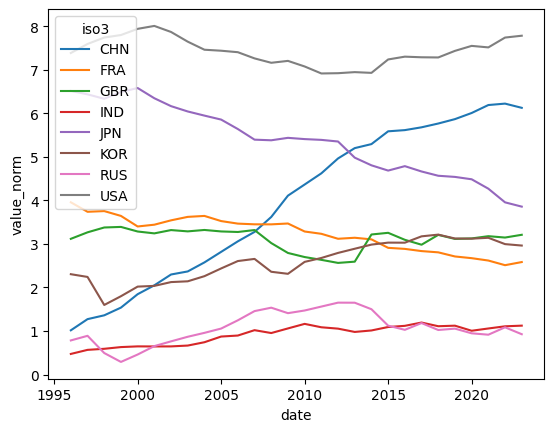

In [72]:
sns.lineplot(data=interpolated_rd_df[interpolated_rd_df["iso3"].isin(["USA", "CHN", "RUS", "FRA", "KOR", "JPN", "GBR", "IND"])],
             x="date", y="value_norm", hue="iso3"
             )

In [74]:
interpolated_rd_df = interpolated_rd_df.drop("value", axis=1).rename(columns={"pct_rd_spending":"value"})

In [75]:
upload_rd_df = rd_handler.format_df_for_upload(dataframe=interpolated_rd_df)

In [78]:
# rd_handler.upload_to_bq(dataframe=upload_rd_df)